In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import scipy.stats as stats

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [9]:
file = 'problem2.csv'

In [24]:
df_ = pd.read_csv(file, sep = ';')

In [62]:
df.tail(3)

,user_id,revenue,testgroup
404767,404768,231,a
404768,404769,0,a
404769,404770,0,b


In [12]:
df.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

In [63]:
def metric_revenue(data):
    
    #количество клиентов в группах
    id_paid_a = df[df.testgroup == 'a'].query("revenue > 0")['user_id'].count()
    id_paid_b = df[df.testgroup == 'b'].query("revenue > 0")['user_id'].count()
    
    #количество пользователей в группах
    id_count_b = df[df.testgroup == 'b']['user_id'].count()
    id_count_a = df[df.testgroup == 'a']['user_id'].count()
    
    #конверсия пользователей в клиентов
    conv_a = round(df[df.testgroup == 'a'].query("revenue > 0")['user_id'].nunique()/df[df.testgroup == 'a']['user_id'].nunique()*100, 2)
    conv_b = round(df[df.testgroup == 'b'].query("revenue > 0")['user_id'].nunique()/df[df.testgroup == 'b']['user_id'].nunique()*100, 2)
    
    #средний чек
    Avg_a = round(df[df.testgroup == 'a']['revenue'].sum()/df[df.testgroup == 'a'].query("revenue > 0")['revenue'].count())
    Avg_b = round(df[df.testgroup == 'b']['revenue'].sum()/df[df.testgroup == 'b'].query("revenue > 0")['revenue'].count())
    
    #медианный средний чек
    Median_paid_a = df[df.testgroup == 'a'].query("revenue > 0")['revenue'].median() 
    Median_paid_b = df[df.testgroup == 'b'].query("revenue > 0")['revenue'].median()
    
    #повторная покупка
    pp_a = df[df.testgroup == 'a'].query("revenue > 0")['revenue'].count()/df[df.testgroup == 'a'].query("revenue > 0")['user_id'].nunique()
    pp_b = df[df.testgroup == 'b'].query("revenue > 0")['revenue'].count()/df[df.testgroup == 'b'].query("revenue > 0")['user_id'].nunique()
    
    #ARPPU = доход/клиенты или повторные покупки*средний чек
    ARPPU_a = round(pp_a*Avg_a)
    ARPPU_b = round(pp_b*Avg_b)
    
    #ARPU = конверсия*доход/клиенты
    ARPU_a = round(conv_a*ARPPU_a)
    ARPU_b = round(conv_b*ARPPU_b)
    
    #максимальный средний чек
    Max_check_a = df[df.testgroup == 'a'].revenue.max()
    Max_check_b = df[df.testgroup == 'b'].revenue.max()
    
    #выручка
    revenue_sum_a = Avg_a*id_paid_a
    revenue_sum_b = Avg_b*id_paid_b
    
    #табличный вывод метрик
    data = {'id_count': [id_count_a, id_count_b], 'id_paid': [id_paid_a, id_paid_b],
           'conv':[conv_a, conv_b], 'avg_check':[Avg_a, Avg_b], 'median_check':[Median_paid_a, Median_paid_b], 'max_check':[Max_check_a, Max_check_b],
           'pp':[pp_a, pp_b], 'ARPPU':[ARPPU_a, ARPPU_b], 'ARPU':[ARPU_a, ARPU_b], 'revenue_sum':[revenue_sum_a, revenue_sum_b]}
    metric_table = pd.DataFrame(data, index=['a', 'b'])
    
    #визуализация распределения revenue
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    plt.title('Boxplot of revenue by group')
    ax = sns.boxplot(x = 'revenue', y = 'testgroup', data = df.query("revenue > 0"))
    fig=ax.get_figure()
    fig.savefig("Boxplot_revenue.png")
    
    return metric_table

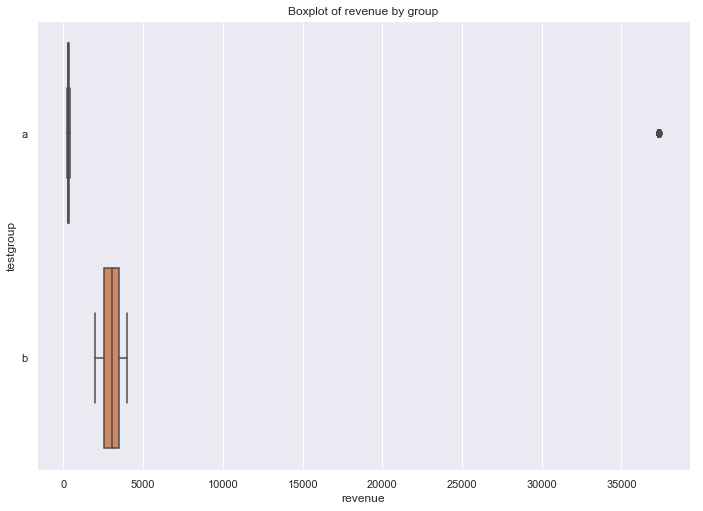

In [64]:
df__ = metric_revenue(df_)


In [65]:
df__

,id_count,id_paid,conv,avg_check,median_check,max_check,pp,ARPPU,ARPU,revenue_sum
a,202103,1928,0.95,2664.0,311.0,37433,1.0,2664.0,2531.0,5136192.0
b,202667,1805,0.89,3004.0,3022.0,4000,1.0,3004.0,2674.0,5422220.0


In [60]:
#количество заказов в группе  А > 10000 руб.
max_orders_a = df_[df_.testgroup == 'a'].query("revenue > 0 & revenue > 10000")['revenue'].count()
max_orders_a

123

In [66]:
# разница выручки в группе А и группе В
5136192.0-5422220.0

-286028.0

In [70]:
#Потенциальное увеличение выручки в группе В при увеличении конверсии до 1%
(2026*3004) - 5422220.0

663884.0

### Выводы:

В контрольной и тестовой группе данные распределились следующим образом:

    группа А - 202103 участников из них 1928, те кто совершил покупку, при этом конверсия составила 0.95
    группа B - 202667 участников из них 1805, те кто совершил покупку, при этом конверсия составила 0.85
    повторных покупок в обоих группах не было, то есть покупатель покупал набор только один раз.
    
не смотря на то, что конверсия в группе В ниже чем в группе A, все остальные метрики выше ARPPU(средний доход на платящего пользователя),
ARPU(средний доход на пользователя), средний чек, а также выручка В группе B выше на 286028 руб.

Интересным представилось проанализировать медианный и максимальный чеки в обоих группах. А также само распределение 
revenue по группам см. BoxPlot
    
По графику мы видим, что в группе А основная масса покупателей покупала наборы в среднем по 311 руб. и лишь небольшая 
группа из 123 покупателей купила наборы по цене более 37000 руб. Что говорит нам о том, перед покупателями стоял сложный выбор 
и они предпочитали покупать минимальный набор по минимальной цене и лишь небольшая группа согласилась приобрести полный набор.
Соответственно необходимо проверить этих покупателей, кто они, что конкретно они покупали, исключить возможность технической ошибки.

Тогда как в группе B практически каждый покупатель купил набор, поторатив при этом от 3000 до 4000 руб. 
То есть покупатели прекрасно отреагировали на предложение не задумываясь покупали акционные товары по заявленной цене.
Покупки стабильные и ровные.

### Рекомендации:
    
1. Выбрать набор B.
2. Проанализировать воронку продаж в группе B.
3. Увеличить конверсию (например, если довести конверсию в этой группе до 1%, при тех же исходный данных
то можно увеличить выручку на 663884 руб.)

Для полного анализа необходимо проанализировать маржинальность предлагаемых наборов, затраты.
Возможно целью данной акции было оценить возможность с помощью акционного предложения продать дорогостоящие наборы по 37 тыс. рублей, 
тогда группа А справилась с поставленной задачей, и необходимо стосредоточиться на оценке этих результатов.